In [ ]:
# %pip install ultralytics

In [2]:
import os
import json

# ✅ Corrected dataset split and annotation path
dataset_split = 'train'  # or 'train', 'valid' if needed
base_dir = f'/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope'
annotation_file = os.path.join(base_dir, 'annotations', f'{dataset_split}_annotations.coco.json')  # confirmed path
base_dir = os.path.join(base_dir, dataset_split)
image_dir = base_dir  # images are in the same folder

# Known corrupted image ID
faulty_image_id = 3736

# Loading annotation data
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Finding the filename of the faulty image
faulty_image = next((img for img in coco_data['images'] if img['id'] == faulty_image_id), None)

if faulty_image:
    faulty_filename = faulty_image['file_name']
    image_path = os.path.join(image_dir, faulty_filename)

    # Removing image file
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"✅ Removed image file: {faulty_filename}")
    else:
        print(f"⚠️ Image file not found: {faulty_filename}")

    # Removing image entry and related annotations from JSON
    coco_data['images'] = [img for img in coco_data['images'] if img['id'] != faulty_image_id]
    coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] != faulty_image_id]

    # Save updated annotations
    with open(annotation_file, 'w') as f:
        json.dump(coco_data, f)

    print("✅ Annotation file cleaned.")
else:
    print("⚠️ Image ID 3736 not found in annotations.")

✅ Removed image file: P0036_1200_2000_3600_4400_png.rf.e499cd87bc2ae09e75192dd84c702865.jpg
✅ Annotation file cleaned.


In [4]:
import os
import json
from tqdm import tqdm

# --- Adjusting paths ---
splits = ['train', 'valid', 'test']
base_path = "/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope"

for split in splits:
    print(f"🛠️ Converting annotations for: {split}")

    json_path = os.path.join(base_path, 'annotations', f"{split}_annotations.coco.json")
    image_dir = os.path.join(base_path, split)
    labels_dir = os.path.join(base_path, split, "labels")

    # label folder
    os.makedirs(labels_dir, exist_ok=True)

    with open(json_path) as f:
        data = json.load(f)

    # lookup tables
    images = {img['id']: img['file_name'] for img in data['images']}
    annotations = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations:
            annotations[image_id] = []
        annotations[image_id].append(ann)

    # Converting each image's annotations to YOLO format
    for image_id, file_name in tqdm(images.items()):
        width = height = 640  # Your dataset uses resized 640x640 images
        label_path = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))

        with open(label_path, "w") as f:
            for ann in annotations.get(image_id, []):
                x, y, w, h = ann['bbox']
                xc = (x + w / 2) / width
                yc = (y + h / 2) / height
                w /= width
                h /= height
                class_id = ann['category_id'] - 1  # YOLO requires class_id starting from 0
                f.write(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ Finished converting {split}.")


🛠️ Converting annotations for: train


100%|██████████| 4716/4716 [00:00<00:00, 66582.30it/s]


✅ Finished converting train.
🛠️ Converting annotations for: valid


100%|██████████| 1346/1346 [00:00<00:00, 68025.03it/s]


✅ Finished converting valid.
🛠️ Converting annotations for: test


100%|██████████| 672/672 [00:00<00:00, 62724.15it/s]

✅ Finished converting test.


In [5]:
dataset_yaml = """
train: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope/train
val: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope/valid

nc: 1
names: ['ship']
"""

with open("/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/sarscope.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ YOLO dataset config written to yolov5/data/sarscope.yaml")

✅ YOLO dataset config written to yolov5/data/sarscope.yaml


In [6]:
import os
import shutil

# valid directory
valid_dir = '/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope/valid'
images_dir = os.path.join(valid_dir, 'images')

# images directory
os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from valid/ to valid/images/
for file in os.listdir(valid_dir):
    if file.endswith('.jpg'):
        src = os.path.join(valid_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.copy(src, dst)

print("✅ Copied validation images into valid/images/")

✅ Copied validation images into valid/images/


In [7]:
import os
import shutil

train_dir = '/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope/train'
images_dir = os.path.join(train_dir, 'images')

os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from train/ to train/images/
for file in os.listdir(train_dir):
    if file.endswith('.jpg'):
        src = os.path.join(train_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.copy(src, dst)

print("✅ Moved training images into train/images/")

✅ Moved training images into train/images/


In [14]:
import ultralytics

yolov8 = ultralytics.YOLO("yolo11n.pt")

In [15]:
results = yolov8.train(data='/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/sarscope.yaml', epochs=5, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.109 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.99 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7965MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/sarscope.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

train: Scanning /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope/train.cache... 4716 images, 4716 backgrounds, 0 corrupt: 100%|██████████| 9432/9432 [00:00<?, ?it/s]
val: Scanning /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope/valid.cache... 1346 images, 1346 backgrounds, 0 corrupt: 100%|██████████| 2692/2692 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.61G      1.592      2.812      1.104         20        640: 100%|██████████| 590/590 [00:55<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:06<00:00, 13.74it/s]


                   all       2692       3781       0.44      0.526      0.347      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.22G      1.504      1.644      1.103         26        640: 100%|██████████| 590/590 [00:53<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:06<00:00, 13.65it/s]

                   all       2692       3781      0.445      0.607      0.375      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.22G      1.437        1.5      1.071          9        640: 100%|██████████| 590/590 [00:52<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:06<00:00, 13.87it/s]

                   all       2692       3781      0.434      0.612      0.377      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.22G      1.359      1.424       1.05          9        640: 100%|██████████| 590/590 [00:52<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:06<00:00, 13.74it/s]

                   all       2692       3781      0.451      0.616      0.391      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.22G      1.262      1.324      1.009         11        640: 100%|██████████| 590/590 [00:52<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:06<00:00, 13.85it/s]

                   all       2692       3781      0.456      0.681      0.417      0.266



5 epochs completed in 0.083 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7965MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:06<00:00, 14.05it/s]


                   all       2692       3781      0.455      0.681      0.418      0.266
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


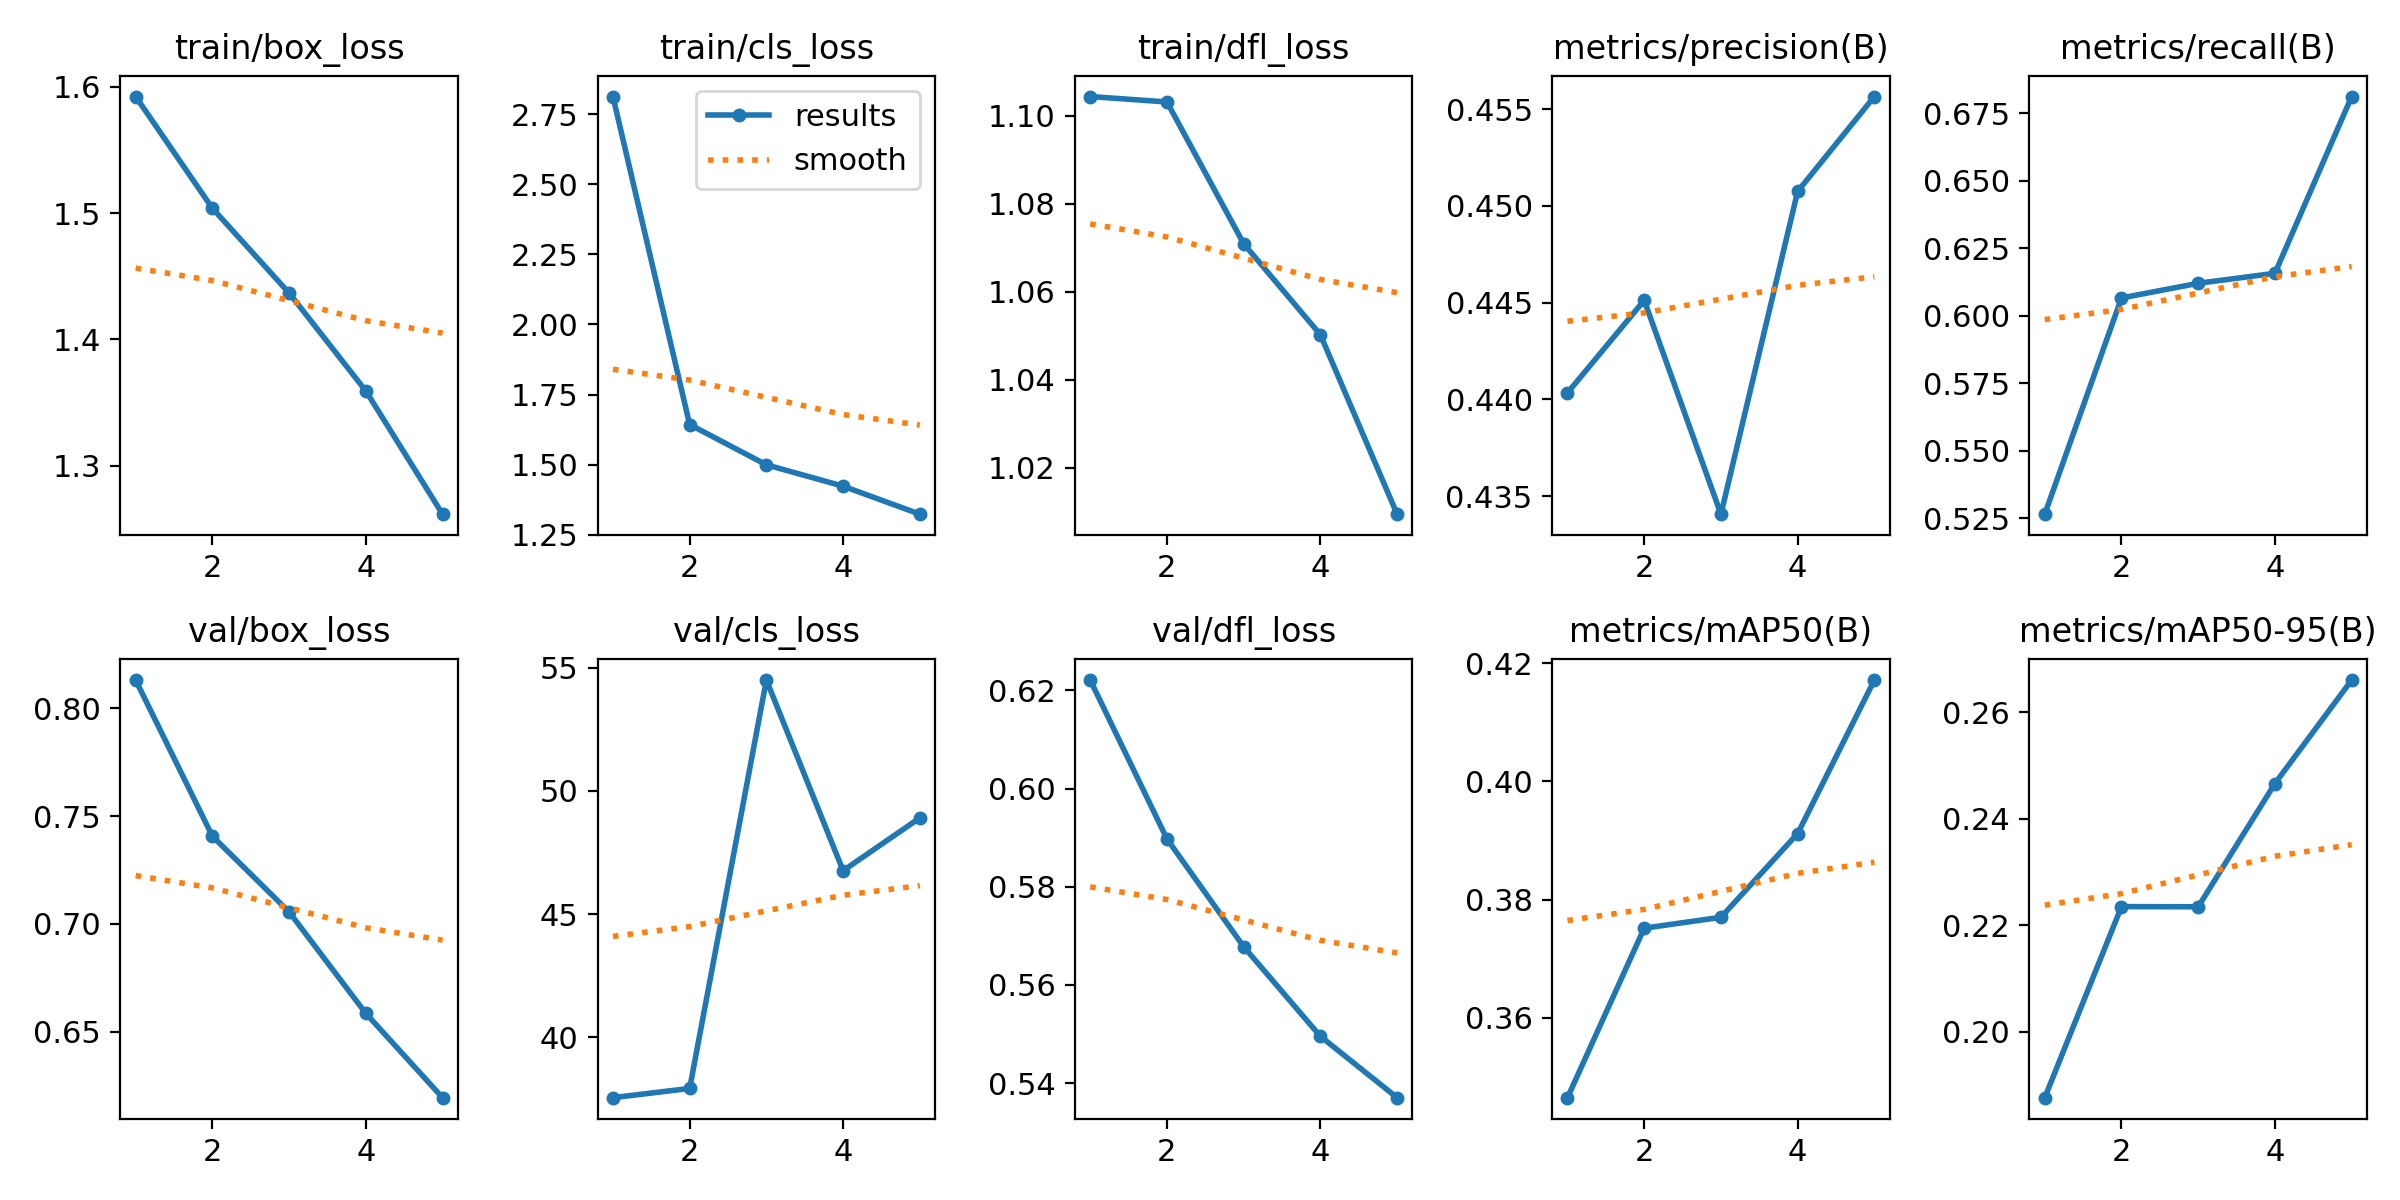

In [17]:
# training results visualization
from IPython.display import Image, display
display(Image(filename='/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/src/runs/detect/train/results.png', width=1000))